# Vanilla

In [1]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
enable_float64 = False
from jax.config import config
config.update("jax_enable_x64", enable_float64)
# config.update("jax_log_compiles", True)
config.update("jax_debug_nans", True)
import json_tricks as json
import copy
from tqdm import tqdm

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import kernel_learning

from jax.experimental import optimizers

key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
target = distributions.Gaussian(0, .1)
proposal = distributions.Gaussian(0, 5)
n_particles = 400
n_iter = 1000
svgd_lr = .05

In [3]:
def makeplots(svgd):
    fig, axs = plt.subplots(2, 2, figsize=[15, 12])
    axs = axs.flatten()
    
    ax=axs[0]
    ax.hist(svgd.get_params()[:, 0], density=True, bins=25)
    ax.plot(svgd.get_params(), np.exp(svgd.loglikelihood), ".", label="Likelihood")
    
    ax=axs[1]
    ax.plot(svgd.rundata["leader_variance"], "--o", label="Leader Variance")
#     ax.plot(svgd.rundata["follower_variance"], "--o", label=" Follower Variance")
    
    ax=axs[2]
    ax.plot(svgd.rundata["KL"], label="KL(q_step || p)")
    ax.set_yscale("log")
    
    ax=axs[3]
    ax.plot(np.diff(svgd.rundata["KL"]), "--o", label="KL diff")
    ax.plot(svgd_lr * np.array(svgd.rundata["KSD"]), "--o", label="KSD*eps")
    ax.set_yscale("log")

    for ax in axs: ax.legend()
    return axs

In [4]:
key, subkey = random.split(key)
s = kernel_learning.SVGD(subkey, target, proposal, n_particles, learning_rate=svgd_lr)

In [5]:
s.flow(n_iter=n_iter)

100%|██████████| 1000/1000 [06:05<00:00,  2.73it/s]


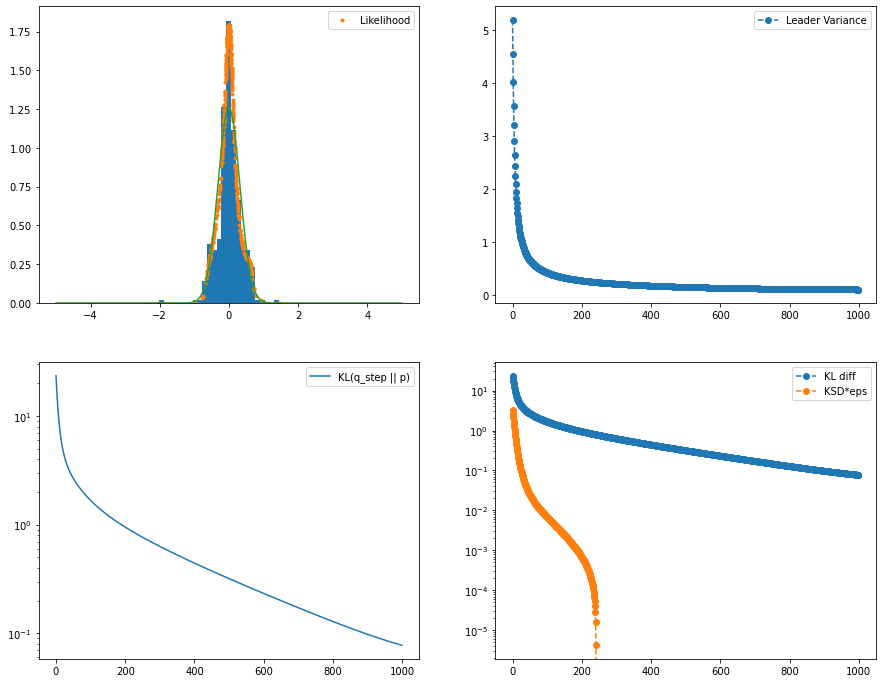

In [6]:
axs = makeplots(s)
plot.plot_fun(target.pdf, lims=(-5, 5), ax=axs[0], label="Target")
plt.legend()

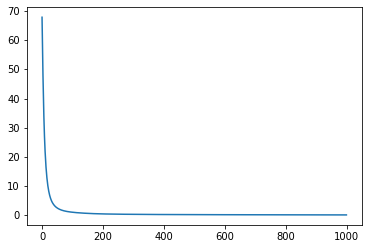

In [7]:
plt.plot(s.rundata["stein_gradient_norm"])

## compare $h = var$

In [8]:
# key, subkey = random.split(key)
s2 = kernel_learning.SVGD(subkey, target, proposal, n_particles, learning_rate=svgd_lr, get_kernel=kernels.get_rbf_kernel)

In [9]:
h = 1
for _ in tqdm(range(n_iter)):
    s2.step(h)
    particles = s2.get_params()
    h = np.var(particles)

100%|██████████| 1000/1000 [06:39<00:00,  2.50it/s]


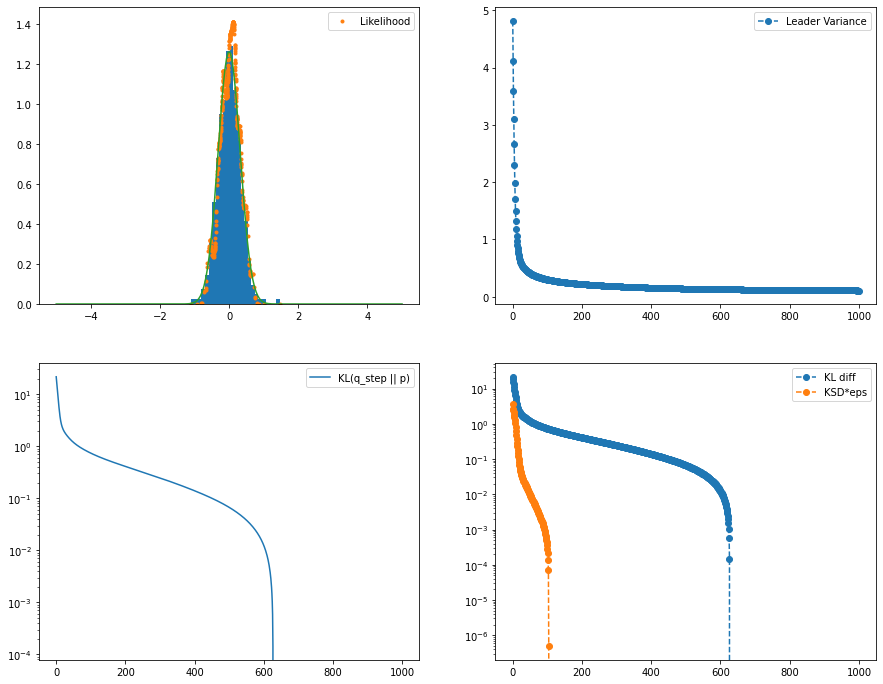

In [10]:
axs = makeplots(s2)
plot.plot_fun(target.pdf, lims=(-5, 5), ax=axs[0], label="Target")